## Pythoni lisade import

In [1]:
# Need koodiread on minu jaoks olnud alati vajalikud, kui kasutada ruumiandmeid pythonis 
import os
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [2]:
from pathlib import Path
import numpy as np
from scipy.spatial import cKDTree
from skimage.graph import MCP_Geometric
from shapely.geometry import Point, LineString, box
from shapely.ops import substring
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from rasterio.transform import xy
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, Normalize
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from tqdm import tqdm
tqdm.pandas()

### Andmete import

#### Raster

In [3]:
dem_dir = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Height_DEM\DEM_1m") # defineerin failide asukoha

In [4]:
dem_files = [
    "53633_dtm_1m.tif",
    "53721_dtm_1m.tif",
    "53722_dtm_1m.tif",
    "53731_dtm_1m.tif"] # defineerin kasutatavad kõrgusmudeli failid

In [5]:
src_files = []
for filename in dem_files:
    filepath = dem_dir / filename
    src = rasterio.open(filepath)
    src_files.append(src) # loen failid sisse

In [6]:
mosaic, out_transform = merge(src_files) # panen failid mosaiigiks kokku

In [7]:
out_meta = src_files[0].meta.copy() # võtan metaandmed kaasa

In [8]:
for src in src_files:
    src.close() # lõpetan failide sisse lugemise

#### Kontroll andmete toimimise üle (Pole otseselt tarvis)

In [9]:
dem_data = mosaic[0] # tekitan maski et peidan nodata väärtused

In [10]:
dem_data = np.ma.masked_where((dem_data < -100) | (dem_data > 10000), dem_data) # peidan nodata väärtused

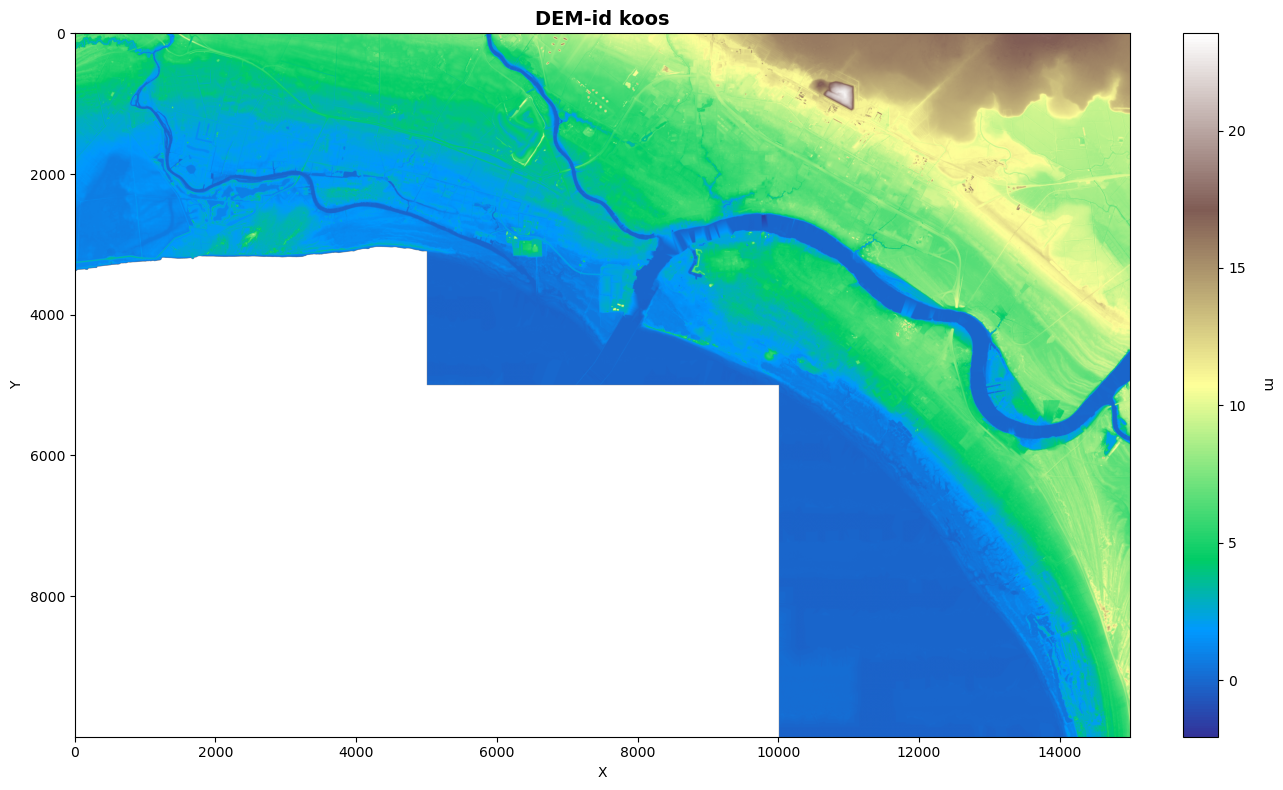

In [11]:
# Kaart, et vaadata kas andmed said õigesti
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(dem_data, cmap='terrain', aspect='equal')
ax.set_title('DEM-id koos', fontsize=14, fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('m', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

#### Rastrite salvestamine üheks failiks

In [14]:
save_dir = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Height_DEM") # defineerin salvestamise asukoha

In [15]:
output_path = save_dir / "merged_DEM_1m.tif" # defineerin salvestava faili nime

In [16]:
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
}) # defineerin salvestatava faili kuju
# salvestan
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic)

### Veetaseme andmete import

In [17]:
raster_path = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Water_lvl_DEM\classified_raster.tif") # defineerin kust ja mille impordin

In [18]:
with rasterio.open(raster_path) as src:
    classified_data = src.read(1) # loen andmed sisse

#### Kontrollin andmete toimimise üle (Pole otseselt tarvis)

In [19]:
classified_masked = np.ma.masked_where((classified_data == 0) | (classified_data < 0) | (classified_data > 10), classified_data) # maskeerin välja nodata

In [20]:
colors = ['#a6cee3', '#1f78b4', '#0d5a8f', '#08306b']
n_classes = 4
cmap = ListedColormap(colors[:n_classes])
bounds = [0.5, 1.5, 2.95, 3.9, 4.5]  # Klasside piirid
norm = BoundaryNorm(bounds, cmap.N)

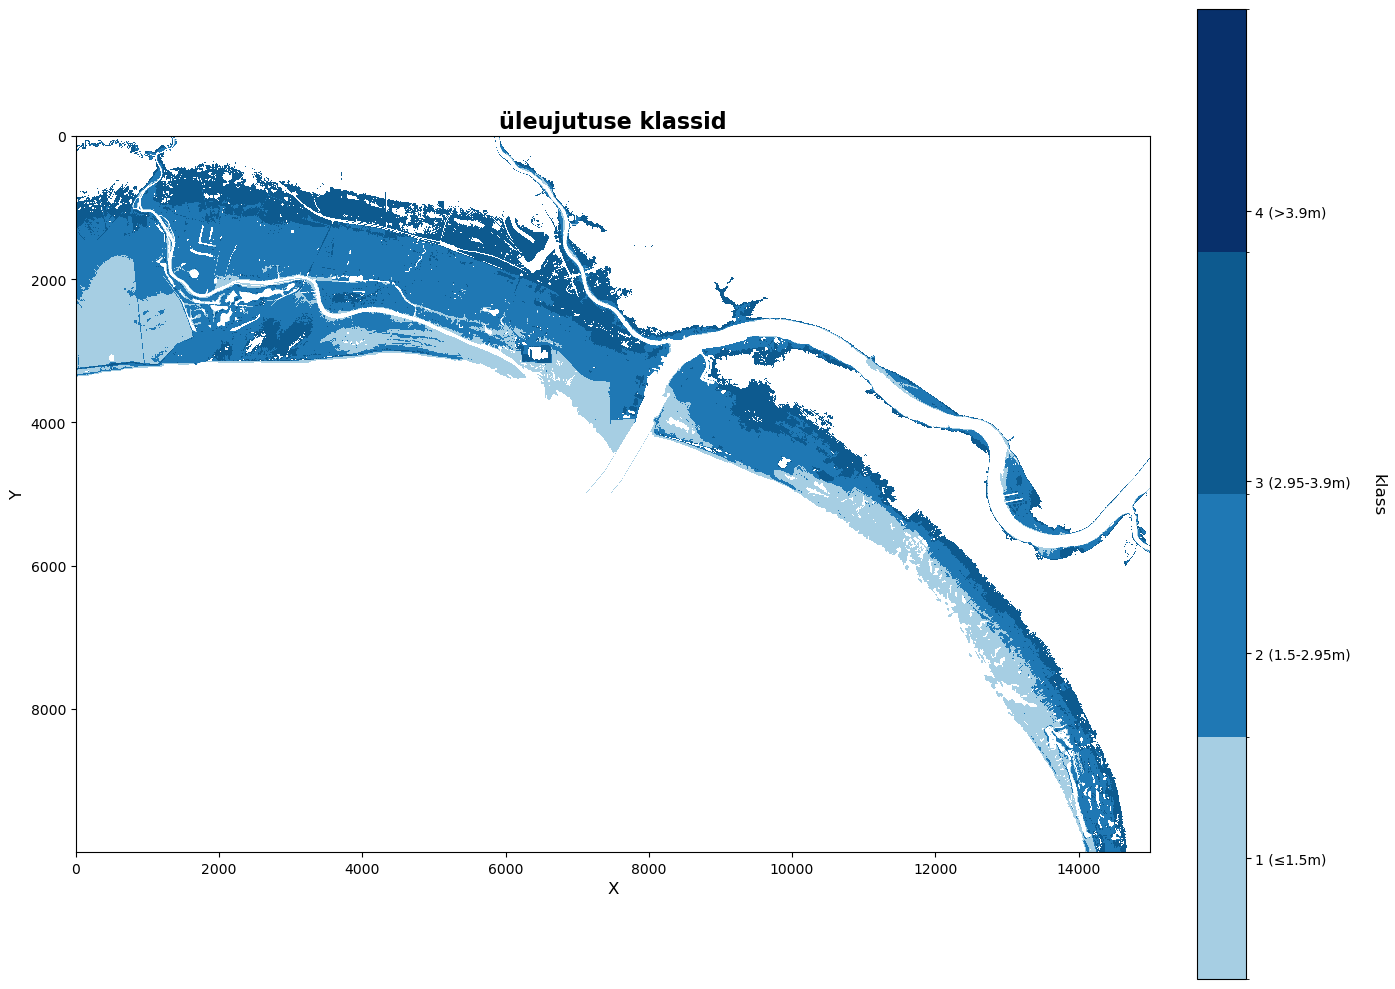

In [21]:
ig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(classified_masked, cmap=cmap, norm=norm, aspect='equal', interpolation='nearest')
ax.set_title('üleujutuse klassid', fontsize=16, fontweight='bold')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)

#legend
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3, 4])
cbar.set_label('klass', rotation=270, labelpad=25, fontsize=12)
cbar.ax.set_yticklabels(['1 (≤1.5m)', '2 (1.5-2.95m)', '3 (2.95-3.9m)', '4 (>3.9m)'], fontsize=10)

plt.tight_layout()
plt.show()

## Andmete eeltöötlus / Vee sügavuse arvutamine

### Import

In [24]:
# Impordin andmed uuesti. Veendun, et andmed oleks töötlemiseks värksed
dem_path = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Height_DEM\merged_DEM_1m.tif")
classified_path = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Water_lvl_DEM\classified_raster.tif") 

### Andmete ühte suurusesse/mõõtu viimine. Igaks juhuks, andmed peaksid küll samas ulatuses olema.

In [25]:
output_dir = Path(r"C:\Users\Dan\Documents\GitHub\Evakuatsiooniteede_mudel\Water_depth_DEM") # defineerin kuhu andmed salvestatakse

In [26]:
# Avan klassifitseeritud veetasemetega rastri. Sealt saab metaandmed et veenduda et rastrid oleksid samas suurused ja koordinaatsüsteemis,
with rasterio.open(classified_path) as classified_src:
    classified_data = classified_src.read(1)
    classified_meta = classified_src.meta.copy()
    classified_transform = classified_src.transform
    classified_crs = classified_src.crs

In [27]:
# Avan DEM rastri. 
with rasterio.open(dem_path) as dem_src:    
    # Loon tühja "array" et sinna salvestada muudetud DEM 
    dem_data = np.empty((classified_data.shape[0], classified_data.shape[1]), dtype=np.float32)
    
    # Muudan andmed et rastrite suurus/ulatus oleks sama.
    reproject(
        source=rasterio.band(dem_src, 1),
        destination=dem_data,
        src_transform=dem_src.transform,
        src_crs=dem_src.crs,
        dst_transform=classified_transform,
        dst_crs=classified_crs,
        resampling=Resampling.bilinear)

### Veesügavuse arvutamise mudel

In [28]:
# Defineerin veetasemed meetrites iga klassi jaoks. 4 neljas klass baasandmetest jääb välja kuna ei kuva olulist infot.
scenarios = {
    'scenario1': {
        'water_level': 1.5,
        'classes': [1],
        'name': '1.5m Üleujutus'
    },
    'scenario2': {
        'water_level': 2.9,
        'classes': [1, 2],
        'name': '2.95m Üleujutus'
    },
    'scenario3': {
        'water_level': 3.9,
        'classes': [1, 2, 3],
        'name': '3.9m Üleujutus'}}

In [29]:
depth_rasters = {} # Hoian siin iga rastri andmeid

In [30]:
for scenario_name, scenario_info in scenarios.items():
    # Loon veesügavuse rastri
    water_depth = np.full_like(dem_data, np.nan, dtype=np.float32)
    # Loon maski mis vaatab ainult antud üleujutusega seonduvaid klasse
    mask = np.isin(classified_data, scenario_info['classes'])
    # Arvutan veesügavuse kasutades antud üleujutusega seonduvat sügavust
    water_depth[mask] = scenario_info['water_level'] - dem_data[mask]
    # Eemaldan väärtused kus sügavus on negatiivne või 0
    water_depth = np.ma.masked_where(water_depth <= 0, water_depth)
    # Hoiustan andmed selleks et kaardid ülevaatamiseks luua
    depth_rasters[scenario_name] = water_depth
    # Salvestan iga üleujutus olukorra eraldi faili et neid oleks hiljem lihtne kasutada
    output_path = output_dir / f"water_depth_{scenario_name}.tif"
    # salvestan metaandmed
    out_meta = classified_meta.copy()
    out_meta.update({
        'dtype': 'float32',
        'nodata': -9999
    })
    # määran NaN väärtuse
    water_depth_save = np.where(np.isnan(water_depth), -9999, water_depth)
    # Kirjutan faili
    with rasterio.open(output_path, 'w', **out_meta) as dest:
        dest.write(water_depth_save, 1)
    
    print(f"  {scenario_info['name']}: {output_path.name}")

  1.5m Üleujutus: water_depth_scenario1.tif
  2.95m Üleujutus: water_depth_scenario2.tif
  3.9m Üleujutus: water_depth_scenario3.tif


### Kaardid ülevaate saamiseks. Pole otseselt tarvis



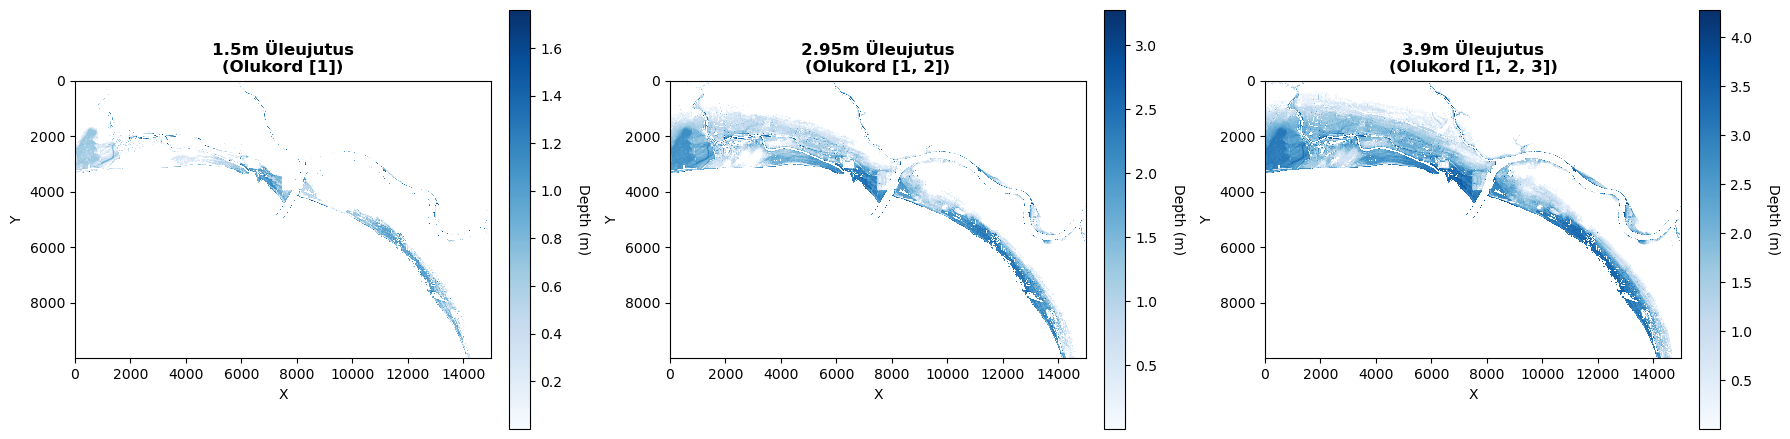

In [31]:
# Kaardid ülevaate saamiseks
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (scenario_name, scenario_info) in enumerate(scenarios.items()):
    water_depth = depth_rasters[scenario_name]
    
    im = axes[idx].imshow(water_depth, cmap='Blues', aspect='equal', interpolation='nearest')
    axes[idx].set_title(f'{scenario_info["name"]}\n(Olukord {scenario_info["classes"]})', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Y')
    
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.set_label('sügavus (m)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()